## Лабораторная работа №4
### Интерполирование функций полиномом Ньютона и естественным сплайном

#### В качестве примера решена задача VI.9.32, в которой требуется построить полином Ньютона и естественный сплайн-аппроксимацию для населения США. А также экстраполировать значение на 2010 год и сравнить точность методов.

| Год  | Численность |
|------|-------------|
| 1910 | 92228496    |
| 1920 | 106021537   |
| 1930 | 123202624   |
| 1940 | 132164569   |
| 1950 | 151325798   |
| 1960 | 179323175   |
| 1970 | 203211926   |
| 1980 | 226545805   |
| 1990 | 248709873   |

#### Точное значение населения США в 2010 году состовляло `308745538` человек.

#### Отметим, что для построения естественного сплайна накладывается дополнительное условие $S''(a) = S''(b) = 0$
#### Построим графики зависимости популяции населения от года для каждого метода и вычислим экстраполяционное значение.
#### Результаты вычислений приведены ниже:


```
Extrapolated population in the USA in 2010:
 Newtons interpolyant -  827906509 
 Spline approximation -  314133939
```
![Image alt](Pictures/newtons_poly.png)


#### По полученным графикам можно сделать вывод, что оба метода дают довольно точную интерполяцию, однако метод Ньютона не пригоден для экстраполянции, в отличие от естественного сплайна, погрешность которого относительно табличных ланных составила порядка $2\%$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def InitPopulation():
    year = list((1910, 1920, 1930, 1940, 1950,
                 1960, 1970, 1980, 1990, 2000))

    population = list((92228496,  106021537, 123202624, 132164569, 151325798,
                       179323175, 203211926, 226545805, 248709873, 281421906))
    return np.array(year), np.array(population)

In [3]:
def DivDiff(x, y, j, i=0):
    if j == i:
        return y[j]
    return (DivDiff(x, y, j, i + 1) - DivDiff(x, y, j - 1, i)) / (x[j] - x[i])

def BasisPoly(node, j):
    if j == 0:
        return lambda x: 1
    return lambda x: BasisPoly(node, j - 1)(x) * (x - node[j-1])

def NewtonsInterpolant(div_diff, basis_poly, j):
    if j == 0:
        return lambda x: 0
    return lambda x: NewtonsInterpolant(div_diff, basis_poly, j - 1)(x) + div_diff[j-1] * basis_poly[j-1](x)

def GetNewtonsInterpolant(x, y):
    div_diff = np.array([DivDiff(x, y, j) for j in range(len(x))])
    basis_poly = np.array([BasisPoly(x, j) for j in range(len(x))])
    return NewtonsInterpolant(div_diff, basis_poly, len(x))

In [189]:
def TridiagonalAlgorithm(h, y):
    size=len(y)
    a = np.zeros(size); b = np.zeros(size)
    c = np.zeros(size); f = np.zeros(size)

    b[0] = b[size - 1] = 1

    for i in range(1, size - 1):
        a[i] = h[i] / 6
        b[i] = (h[i] + h[i+1]) / 3
        c[i] = h[i+1] / 6
        f[i] = (y[i+1] - y[i]) / h[i+1] - (y[i] - y[i - 1]) / h[i]

    alpha = np.zeros(size); beta = np.zeros(size)

    for i in range(size - 1):
        alpha[i+1] = - c[i] / (a[i] * alpha[i] + b[i])
        beta[i+1]  = (f[i] - a[i] * beta[i]) / (a[i] * alpha[i] + b[i])

    x = np.zeros(size)
    x[size - 1] = (f[size - 1] - a[size - 1] * beta[size - 1]) / \
                  (a[size - 1] * alpha[size - 1] + b[size - 1])

    for i in reversed(range(size - 1)):
        x[i] = alpha[i+1] * x[i+1] + beta[i+1]

    return x

def GetSpline(x, y):
    h = np.zeros(len(x))
    for i in range(1, len(x)):
        h[i] = x[i] - x[i-1]

    c = TridiagonalAlgorithm(h, y)
    a = np.zeros(len(c)); b = np.zeros(len(c))
    d = np.zeros(len(c))

    for i in range(1, len(d)):
        a[i] = y[i]
        d[i] = (c[i] - c[i-1]) / h[i]
        b[i] = (2 * c[i] + c[i-1]) / 6 * h[i] + (y[i] - y[i - 1]) / h[i]

    S = lambda X, i: a[i] + b[i] * (X - x[i]) + 0.5 * c[i] * ((X - x[i]) ** 2) + 1/6 * d[i] * ((X - x[i]) ** 3)

    def Spline(X):
        if X <= x[1]:
            return S(X, 1)
        elif X > x[len(x) - 1]:
            return S(X, len(x) - 1)
        else:
            for i in range(1, len(x)):
                if X > x[i - 1] and X <= x[i]:
                    return S(X, i)

    return Spline

Extrapolated population in the USA in 2010:
 Newtons interpolyant -  827906509 
 Spline approximation -  314133939


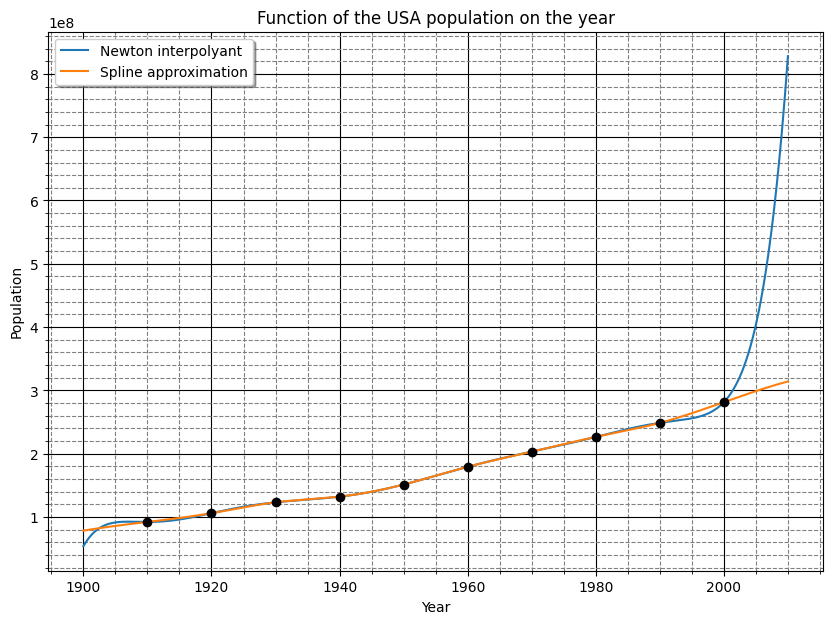

In [188]:
def main():
    year, population = InitPopulation()
    newtons_interpolyant = GetNewtonsInterpolant(year, population)
    spline = GetSpline(year, population)
    print("Extrapolated population in the USA in 2010:\n",
          "Newtons interpolyant - ", int(newtons_interpolyant(2010)), "\n",
          "Spline approximation - ", int(spline(2010)))

    fig, ax = plt.subplots(figsize=[10, 7])
    ax.set_title("Function of the USA population on the year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Population")
    
    year_seq = np.linspace(1900, 2010, 1000)
    spline_val = np.array([spline(year_seq[i]) for i in range(len(year_seq))])

    ax.plot(year_seq, newtons_interpolyant(year_seq), label='Newton interpolyant')
    ax.plot(year_seq, spline_val, label='Spline approximation')
    ax.legend(shadow=True)

    ax.plot(year, population, 'o', color='black')
    plt.minorticks_on()
    plt.grid(which='major', color='black', linestyle='-')
    plt.grid(which='minor', color='0.5', linestyle='--')

main()